<a href="https://colab.research.google.com/github/maiormarso/DS-Unit-2-Linear-Models/blob/master/module4-logistic-regression/LS_DS9_214_assignment_burrito_regression_classification_4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Lambda School Data Science

*Unit 2, Sprint 1, Module 4*

---

# Logistic Regression


## Assignment 🌯

You'll use a [**dataset of 400+ burrito reviews**](https://srcole.github.io/100burritos/). How accurately can you predict whether a burrito is rated 'Great'?

> We have developed a 10-dimensional system for rating the burritos in San Diego. ... Generate models for what makes a burrito great and investigate correlations in its dimensions.

- [ ] Do train/validate/test split. Train on reviews from 2016 & earlier. Validate on 2017. Test on 2018 & later.
- [ ] Begin with baselines for classification.
- [ ] Use scikit-learn for logistic regression.
- [ ] Get your model's validation accuracy. (Multiple times if you try multiple iterations.)
- [ ] Get your model's test accuracy. (One time, at the end.)
- [ ] Commit your notebook to your fork of the GitHub repo.
- [ ] Watch Aaron's [video #1](https://www.youtube.com/watch?v=pREaWFli-5I) (12 minutes) & [video #2](https://www.youtube.com/watch?v=bDQgVt4hFgY) (9 minutes) to learn about the mathematics of Logistic Regression.


## Stretch Goals

- [ ] Add your own stretch goal(s) !
- [ ] Make exploratory visualizations.
- [ ] Do one-hot encoding.
- [ ] Do [feature scaling](https://scikit-learn.org/stable/modules/preprocessing.html).
- [ ] Get and plot your coefficients.
- [ ] Try [scikit-learn pipelines](https://scikit-learn.org/stable/modules/compose.html).

In [0]:
import pandas as pd
df = pd.read_csv('https://raw.githubusercontent.com/LambdaSchool/DS-Unit-2-Linear-Models/master/data/burritos/burritos.csv')

In [45]:
df.head(1)

,Location,Burrito,Date,Neighborhood,Address,URL,Yelp,Google,Chips,Cost,Hunger,Mass (g),Density (g/mL),Length,Circum,Volume,Tortilla,Temp,Meat,Fillings,Meat:filling,Uniformity,Salsa,Synergy,Wrap,overall,Rec,Reviewer,Notes,Unreliable,NonSD,Beef,Pico,Guac,Cheese,Fries,Sour cream,Pork,Chicken,Shrimp,Fish,Rice,Beans,Lettuce,Tomato,Bell peper,Carrots,Cabbage,Sauce,Salsa.1,Cilantro,Onion,Taquito,Pineapple,Ham,Chile relleno,Nopales,Lobster,Queso,Egg,Mushroom,Bacon,Sushi,Avocado,Corn,Zucchini
0,Donato's taco shop,California,1/18/2016,Miramar,6780 Miramar Rd,http://donatostacoshop.net/,3.5,4.2,NaN,6.49,3.0,NaN,NaN,NaN,NaN,NaN,3.0,5.0,3.0,3.5,4.0,4.0,4.0,4.0,4.0,3.8,NaN,Scott,good fries: 4/5,NaN,NaN,x,x,x,x,x,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [0]:
# Derive binary classification target:
# We define a 'Great' burrito as having an
# overall rating of 4 or higher, on a 5 point scale.
# Drop unrated burritos.
df = df.dropna(subset=['overall'])
df['Great'] = df['overall'] >= 4

In [0]:
# Clean/combine the Burrito categories
df['Burrito'] = df['Burrito'].str.lower()

california = df['Burrito'].str.contains('california')
asada = df['Burrito'].str.contains('asada')
surf = df['Burrito'].str.contains('surf')
carnitas = df['Burrito'].str.contains('carnitas')

df.loc[california, 'Burrito'] = 'California'
df.loc[asada, 'Burrito'] = 'Asada'
df.loc[surf, 'Burrito'] = 'Surf & Turf'
df.loc[carnitas, 'Burrito'] = 'Carnitas'
df.loc[~california & ~asada & ~surf & ~carnitas, 'Burrito'] = 'Other'

In [0]:
# Drop some high cardinality categoricals
df = df.drop(columns=['Notes', 'Location', 'Reviewer', 'Address', 'URL', 'Neighborhood'])

In [0]:
# Drop some columns to prevent "leakage"
df = df.drop(columns=['Rec', 'overall'])

In [0]:
df.tail(20)

In [88]:
df.Burrito.value_counts()

California     169
Other          156
Asada           43
Surf & Turf     28
Carnitas        25
Name: Burrito, dtype: int64

In [0]:
burrito_dict = {'California': 0,'Other': 1,'Asada': 2,'Surf & Turf':3,'Carnitas':4}

In [0]:
df['Burrito']=df['Burrito'].replace(burrito_dict)

In [92]:
df.Burrito

0      0
1      0
2      4
3      2
4      0
      ..
418    1
419    1
420    0
421    1
422    1
Name: Burrito, Length: 421, dtype: int64

###10 Dimensional Burrito
1. Volume - “size matters,” “bigger is better,” or whatever your favorite innuendo is fits because there’s nothing more disconcerting than ordering a burrito and not being full.
2. Tortilla quality
3. Temperature - the Goldilocks zone
4. Meat quality
5. Non-meat filling quality
6. Meat : filling - The ratio between meat and non-meat. Perhaps the golden ratio: 1.6180339887…
7. Uniformity - Bites full of sour cream and cheese with no meat are disappointing.
8. Salsa quality - and variety!
9. Flavor synergy - "That magical aspect a great burrito has, making everything come together like it is a gift from the skies" - A wise Dutchman
10.Wrap integrity - you ordered a burrito, not a burrito bowl.

In [51]:
df.shape 

(421, 59)

In [0]:
df['Date'] = pd.to_datetime(df['Date'], infer_datetime_format=True)

In [53]:
train = df[df.Date.dt.year <= 2016]
val = df[df.Date.dt.year == 2017]
test = df[df.Date.dt.year >= 2018]

train.shape, val.shape, test.shape

((298, 59), (85, 59), (38, 59))

 ##Begin with baselines for classification.

In [54]:
target='Great'
train[target].value_counts(normalize=True)

False    0.590604
True     0.409396
Name: Great, dtype: float64

###Use scikit-learn for logistic regression.

In [0]:
features = ['Length','Circum','Volume','Tortilla','Temp','Meat','Fillings',
            'Meat:filling','Uniformity','Salsa','Synergy','Wrap']

In [0]:
X_train=train[features]
y_train=train[target]
X_val=val[features]
y_val=val[target]

In [62]:
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegressionCV
from sklearn.preprocessing import StandardScaler

imputer = SimpleImputer()
X_train_imputed = imputer.fit_transform(X_train)
X_val_imputed = imputer.transform(X_val)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_imputed)
X_val_scaled = scaler.transform(X_val_imputed)

model = LogisticRegressionCV(cv=5, n_jobs=-1, random_state=42)
model.fit(X_train_scaled, y_train)
print('Validation Accuracy', model.score(X_val_scaled, y_val))

Validation Accuracy 0.8823529411764706


###one-hot-encoding

In [76]:
import category_encoders as ce

features = train.columns.drop([target, 'Date'])
X_train = train[features]
X_val = val[features]

encoder = ce.OneHotEncoder(use_cat_names=True)
X_train_encoded = encoder.fit_transform(X_train)
X_val_encoded = encoder.transform(X_val)

imputer = SimpleImputer()
X_train_imputed = imputer.fit_transform(X_train_encoded)
X_val_imputed = imputer.transform(X_val_encoded)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_imputed)
X_val_scaled = scaler.transform(X_val_imputed)

model = LogisticRegressionCV(cv=5, n_jobs=-1, random_state=42)
model.fit(X_train_scaled, y_train)

print('Validation Accuracy', model.score(X_val_scaled, y_val))

Validation Accuracy 0.7647058823529411


In [97]:
X_train[features]

,Burrito,Yelp,Google,Chips,Cost,Hunger,Mass (g),Density (g/mL),Length,Circum,Volume,Tortilla,Temp,Meat,Fillings,Meat:filling,Uniformity,Salsa,Synergy,Wrap,Unreliable,NonSD,Beef,Pico,Guac,Cheese,Fries,Sour cream,Pork,Chicken,Shrimp,Fish,Rice,Beans,Lettuce,Tomato,Bell peper,Carrots,Cabbage,Sauce,Salsa.1,Cilantro,Onion,Taquito,Pineapple,Ham,Chile relleno,Nopales,Lobster,Queso,Egg,Mushroom,Bacon,Sushi,Avocado,Corn,Zucchini
0,California,3.5,4.2,NaN,6.49,3.0,NaN,NaN,NaN,NaN,NaN,3.0,5.0,3.0,3.5,4.0,4.0,4.0,4.0,4.0,NaN,NaN,x,x,x,x,x,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,California,3.5,3.3,NaN,5.45,3.5,NaN,NaN,NaN,NaN,NaN,2.0,3.5,2.5,2.5,2.0,4.0,3.5,2.5,5.0,NaN,NaN,x,x,x,x,x,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Carnitas,NaN,NaN,NaN,4.85,1.5,NaN,NaN,NaN,NaN,NaN,3.0,2.0,2.5,3.0,4.5,4.0,3.0,3.0,5.0,NaN,NaN,NaN,x,x,NaN,NaN,NaN,x,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Asada,NaN,NaN,NaN,5.25,2.0,NaN,NaN,NaN,NaN,NaN,3.0,2.0,3.5,3.0,4.0,5.0,4.0,4.0,5.0,NaN,NaN,x,x,x,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,California,4.0,3.8,x,6.59,4.0,NaN,NaN,NaN,NaN,NaN,4.0,5.0,4.0,3.5,4.5,5.0,2.5,4.5,4.0,NaN,NaN,x,x,NaN,x,x,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
296,California,4.0,4.3,NaN,5.65,3.0,NaN,NaN,19.5,22.0,0.75,4.0,1.5,2.0,3.0,4.2,4.0,3.0,2.0,4.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
297,Other,NaN,NaN,NaN,5.49,3.0,NaN,NaN,19.0,20.5,0.64,4.5,5.0,2.0,2.0,2.5,3.5,3.0,2.5,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
298,California,3.5,3.7,NaN,7.75,4.0,NaN,NaN,20.0,21.0,0.70,3.5,2.5,3.0,3.3,1.4,2.3,2.2,3.3,4.5,NaN,NaN,X,X,NaN,X,X,X,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
299,Asada,NaN,NaN,NaN,7.75,4.0,NaN,NaN,19.5,21.0,0.68,4.0,4.5,2.0,2.0,3.5,3.5,2.0,2.0,4.0,NaN,NaN,X,X,X,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [0]:
features = ['Volume','Tortilla','Temp','Meat','Fillings',
           'Meat:filling','Uniformity','Salsa','Synergy','Wrap']

X_train = train[features]

imputer = SimpleImputer()
X_train_imputed = imputer.fit_transform(X_train)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_imputed)

model = LogisticRegressionCV(cv=5, n_jobs=-1, random_state=42)
model.fit(X_train_scaled, y_train);       

In [103]:
X_test = test[features]
y_test = test[target]
X_test_imputed = imputer.transform(X_test)
X_test_scaled = scaler.transform(X_test_imputed)
print('Test Accuracy', model.score(X_test_scaled, y_test))

Test Accuracy 0.7894736842105263


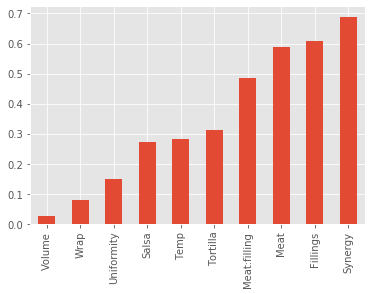

In [106]:
%matplotlib inline
import matplotlib
matplotlib.style.use('ggplot')
coefficients = pd.Series(model.coef_[0], features)
coefficients.sort_values().plot.bar();